In [1]:
%load_ext memory_profiler

In [2]:
#import necessary packages
import numpy as np
import sys
import math
import pickle
import re
import isoprene_rates as rate
from math import exp as EXP
from copy import deepcopy
import matplotlib.pyplot as plt
import time
import csv
import pandas as pd
import random
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.csgraph import csgraph_from_dense
from scipy.sparse import lil_matrix
from scipy.sparse.csgraph import connected_components

In [3]:
# Import the AMORE algorithm

In [4]:
import AMORE_v2 as am

# Camphene

In [6]:
# Camphene Rate Functions

In [7]:
def arrhenius(A,n,Ea,T):
    rate = A*(T**n)*math.exp(-Ea/T)
    return rate

def ISOM(a1,a2,a3,f1,f2,f3,f4,f5, temp, m):
    ar = arrhenius(a1,a2,a3,temp)
    iso = f1*(temp**4) + f2*(temp**3) + f3*(temp**2) + f4*temp + f5
    
    return iso*ar

def extra(a1,a2,a3,f1,temp,m):
    ar = arrhenius(a1,a2,a3, temp)
    return ar
def falloff(a1,a2,a3,f1,f2,f3,f4,f5,f6,f7,temp,m):
    e1 = f1*((temp/300)**f2)*math.exp(-f3/temp)*m
    r1 = e1/(a1*((temp/300)**a2))*math.exp(-a3/temp)
    fr1 = 1/(1+((math.log10(r1))**2))
    if f5 == 0 or f6 == 0:
        lnrate = math.log(e1/(1+r1)) + fr1*math.log(f4)
    else:
        fr2 = (1-f4)*math.exp(-temp/f5) + f4*math.exp(-temp/f6) + math.exp(-f7/temp)
        if f7== 0:
            fr2 = fr2 -1
        lnrate = math.log(e1/(1+r1)) + fr1*math.log(fr2)
    return math.exp(lnrate)
def get_rates(rate_numbers, rate_type,a_list_2,b_list_3,temp,press,M,sza):
    rates = []
    for i in range(len(rate_numbers)):
        if rate_type[i] == 'WALL':
            rates.append(0)
        elif rate_type[i] == 'HV':
            ind = a_list_2.index(rate_numbers[i][1][0])
            ind2 = b_list_3[ind].index(sza)
            r = b_list_3[ind][ind2+1]*rate_numbers[i][1][1]
            rates.append(r)
        elif rate_type[i] == 'FALLOFF':
            rates.append(falloff(rate_numbers[i][0][0],rate_numbers[i][0][1],rate_numbers[i][0][2],rate_numbers[i][1][0],rate_numbers[i][1][1],rate_numbers[i][1][2],rate_numbers[i][1][3],rate_numbers[i][1][4],rate_numbers[i][1][5],rate_numbers[i][1][6],temp,M))
        elif rate_type[i] == 'NORMAL':
            r = arrhenius(rate_numbers[i][0],rate_numbers[i][1],rate_numbers[i][2],temp)
            rates.append(r)
        elif rate_type[i]=='ISOM':
            r = ISOM(rate_numbers[i][0][0], rate_numbers[i][0][1],rate_numbers[i][0][2], rate_numbers[i][1][0], rate_numbers[i][1][1], rate_numbers[i][1][2], rate_numbers[i][1][3], rate_numbers[i][1][4],temp,M)
            rates.append(r)
        elif rate_type[i]=='EXTRA':
            r = extra(rate_numbers[i][0][0], rate_numbers[i][0][1],rate_numbers[i][0][2], rate_numbers[i][1][0],temp,M)
            rates.append(r)
        else:
            rates.append(0)
    return rates
CFACTOR = 2.5e+19;
RO2 = 0.01*10e-9;
SUN = 0.5;
TEMP = 295;
M = am.pressure_to_m(1000,295);
sza = 0;

In [9]:
# old files
folder = 'C:/Users/woods/OneDrive/Documents/Python/Code/camphene_6g_with_spinup/'
dict_str = 'C:/Users/woods/OneDrive/Documents/Python/Code/camphene_6gen_mech_dictionary.dict'
mech_str = 'C:/Users/woods/OneDrive/Documents/Python/Code/Camphene_6gen_mechanism.txt'

In [10]:
vol_str = 'C:/Users/woods/OneDrive/Documents/Python/Code/camphene_6g_with_spinup/camphene_6g.psim'

In [11]:
fileObject = open(vol_str, "r")
vol = fileObject.read()
vol_raw = vol.split('\n')[5:-2]


In [12]:
vol_dic = {}
for i in vol_raw:
    vol_dic[i.split('   ')[0]] = float(i.split('   ')[1])
    

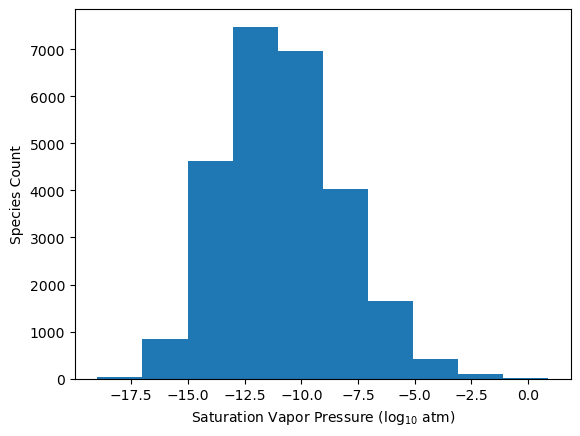

In [13]:
vols = []
for i in vol_dic:
    vols.append(np.log10(vol_dic[i]))
plt.hist(vols)
plt.xlabel("Saturation Vapor Pressure (log$_{10}$ atm)")
plt.ylabel("Species Count")
plt.savefig('vapor_pressure.png')

In [14]:
henry_str = 'C:/Users/woods/OneDrive/Documents/Python/Code/camphene_6g_with_spinup/camphene_6g.henry'

In [15]:
fileObject = open(henry_str, "r")
henry = fileObject.read()
henry_raw = henry.split('\n')[:-2]


In [16]:
mech_str_m = 'C:/Users/woods/OneDrive/Documents/Python/Code/AMORE_v2_paper_files/GECKO Mech copy/camphene_177/camphene200.mech'
fileObject = open(mech_str_m, "r")
m_raw = fileObject.read()
mech_m_raw = m_raw.split('\n')[:-2]

In [17]:
mech_m_raw = mech_m_raw[4:-1]

In [18]:
r_lsit = set()
for i in mech_m_raw:
    r_lsit.add(i.split('=>')[0])

In [19]:
henry_dic = {}
for i in henry_raw:
    henry_dic[i.split('  ')[3].split(' ')[0]] = float(i.split('  ')[1])
    

In [20]:
henry_dat = []
vol_dat = []
species_for_cat = []
for i in vol_dic:
    if i in henry_dic:
        henry_dat.append(np.log10(henry_dic[i]))
        vol_dat.append(np.log10(vol_dic[i]))
        species_for_cat.append(i)

In [21]:
for i in vol_dic:
    if i not in henry_dic:
        print('yes')

Text(0, 0.5, 'Vol')

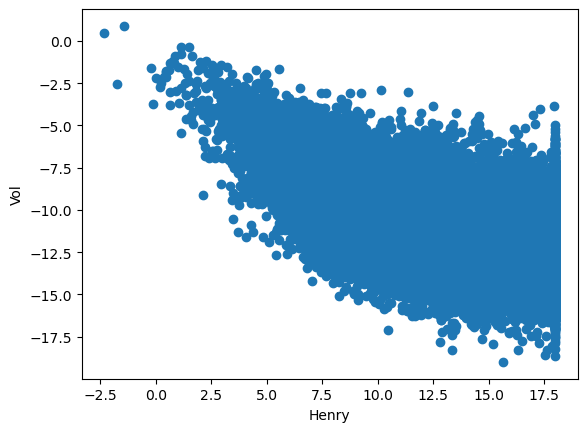

In [22]:
plt.scatter(henry_dat, vol_dat)
plt.xlabel("Henry")
plt.ylabel("Vol")

In [23]:
from sklearn.cluster import KMeans

In [24]:
data = []
for i in range(len(henry_dat)):
    data.append([henry_dat[i], vol_dat[i]])

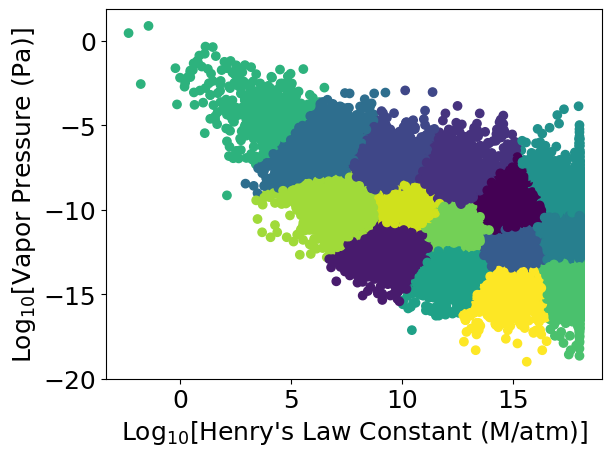

In [25]:


plt.rcParams['font.size'] = 18
kmeans = KMeans(n_clusters=15)
kmeans.fit(data)

plt.scatter(henry_dat, vol_dat, c=kmeans.labels_)
plt.yticks([0,-5,-10,-15,-20]) 
plt.xticks([0,5,10,15]) 

#plt.scatter(np.log10(1800000000), np.log10(7.345e-08), color='red')
#plt.scatter(np.log10(16000000000.0), np.log10(5.905e-12), color='red')
plt.ylabel('Log$_{10}$[Vapor Pressure (Pa)]')
plt.xlabel("Log$_{10}$[Henry's Law Constant (M/atm)]")
plt.savefig('henrys_law.png', dpi=300, bbox_inches='tight')

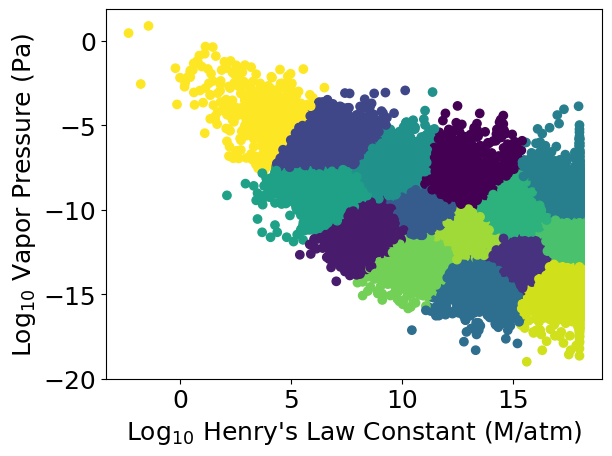

In [26]:


plt.rcParams['font.size'] = 18
kmeans = KMeans(n_clusters=15)
kmeans.fit(data)

plt.scatter(henry_dat, vol_dat, c=kmeans.labels_)
plt.yticks([0,-5,-10,-15,-20]) 
plt.xticks([0,5,10,15]) 


#plt.scatter(np.log10(1800000000), np.log10(7.345e-08), color='red')
#plt.scatter(np.log10(16000000000.0), np.log10(5.905e-12), color='red')
plt.ylabel('Log$_{10}$ Vapor Pressure (Pa)')
plt.xlabel("Log$_{10}$ Henry's Law Constant (M/atm)")
plt.savefig('henrys_law.png', dpi=100, bbox_inches='tight')

In [27]:
clusters = kmeans.cluster_centers_

In [28]:
center_specs = []
for j in range(len(clusters)):
    dists = []
    for i in range(len(henry_dat)):
        dists.append(np.sqrt((henry_dat[i]-clusters[j][0])**2 + (vol_dat[i]-clusters[j][1])**2))
    
    center_specs.append(species_for_cat[dists.index(min(dists))])

In [29]:
cat_dict = {i:[] for i in range(15)}
for i in range(len(kmeans.labels_)):
    cat_dict[kmeans.labels_[i]].append(species_for_cat[i][1:])

In [31]:
import pickle

with open('cat_dict_50_new.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(cat_dict, f, pickle.HIGHEST_PROTOCOL)

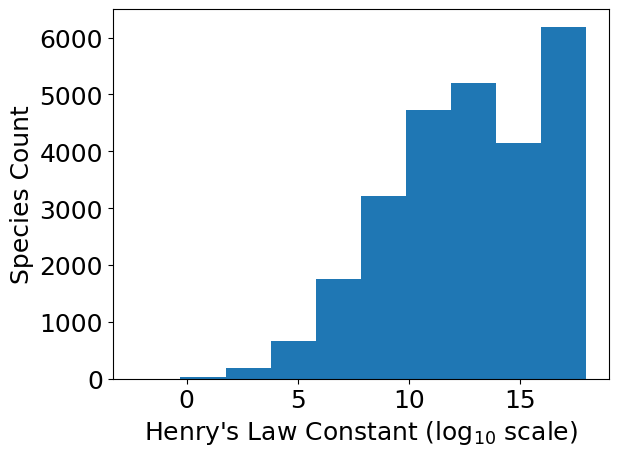

In [32]:
henrys = []
for i in henry_dic:
    henrys.append(np.log10(henry_dic[i]))
plt.hist(henrys)
plt.xlabel("Henry's Law Constant (log$_{10}$ scale)")
plt.ylabel("Species Count")
plt.savefig('henrys_law.png')

In [33]:
#preamble
folder = 'C:/Users/woods/OneDrive/Documents/Python/Code/propane/'
dict_str = 'C:/Users/woods/OneDrive/Documents/Python/Code/camphene_6g_with_spinup/camphene_6g.dict'
mech_str = 'C:/Users/woods/OneDrive/Documents/Python/Code/camphene_6g_with_spinup/camphene_6g.mech'
fileObject = open(dict_str, "r")
dict_spec = fileObject.read()
fileObject = open(mech_str, "r")
mech = fileObject.read()
species_list_raw = dict_spec.split('\n')
species_list_names = [i.split(' ')[0] for i in species_list_raw]
#mech_str = 'C:/Users/woods/OneDrive/Documents/Python/Code/Camphene_6gen_mechanism.txt'
fileObject = open(dict_str, "r")
dict_spec = fileObject.read()
fileObject = open(mech_str, "r")
mech = fileObject.read()
mech_list_raw = mech.rsplit('\n')[4:]
mech_list_raw.remove('')
for i in range(len(mech_list_raw)):
    if mech_list_raw[i][0] != 'G' and mech_list_raw[i][0] != 'A' and mech_list_raw[i][0] != 'W':
        mech_list_raw[i-1] = mech_list_raw[i-1] + mech_list_raw[i]
        mech_list_raw[i] = ''
mech_list_raw_2 = []
for i in mech_list_raw:
    if i != '':
        mech_list_raw_2.append(i)
# separating reactants, products and rates
reacs_raw = []
prods_raw = []
rates_raw = []
count = 0
#photo table
fileObject = open(folder + "O3_300DU.phot","r")
photo_table = fileObject.read()
for i in mech_list_raw_2:
    if 'E-' in i and 'E+' in i:
        ll1 = i.split('E-',1)
        ll2 = i.split('E+',1)
        if len(ll1[0])>len(ll2[0]):
            ll = ll2
            mark = 'E+'
        else:
            ll = ll1
            mark = 'E-'
        reac_prod = ll[0][:-5]
        rates = ll[0][-5:] + mark + ll[1]
        rp = reac_prod.split('=>')
        reacs_raw.append(rp[0])
        if len(rp)>1:
            prods_raw.append(rp[1])
        else:
            prods_raw.append('')
        rates_raw.append(rates)
    elif 'E-' in i:
        ll = i.split('E-',1)
        reac_prod = ll[0][:-5]
        rates = ll[0][-5:] + 'E-' + ll[1]
        rp = reac_prod.split('=>')
        reacs_raw.append(rp[0])
        if len(rp)>1:
            prods_raw.append(rp[1])
        else:
            prods_raw.append('')
        rates_raw.append(rates)
    elif 'E+' in i:
        ll = i.split('E+',1)
        reac_prod = ll[0][:-5]
        rates = ll[0][-5:] + 'E+' + ll[1]
        rp = reac_prod.split('=>')
        reacs_raw.append(rp[0])
        if len(rp)>1:
            prods_raw.append(rp[1])
        else:
            prods_raw.append('')
        rates_raw.append(rates)
    count = count + 1
if 'END' in rates_raw[-1]:
    print(rates_raw[-1])
    rates_raw[-1] = rates_raw[-1][:-3]
    print(rates_raw[-1])
# separating reactants, products and rates
rates_raw_2 = []
rxn_raw = []
for i in mech_list_raw_2:
    if 'E-' in i and 'E+' in i:
        ll1 = i.split('E-',1)
        ll2 = i.split('E+',1)
        if len(ll1[0])>len(ll2[0]):
            ll = ll2
            mark = 'E+'
        else:
            ll = ll1
            mark = 'E-'
        reac_prod = ll[0][:-5]
        rates = ll[0][-5:] + mark + ll[1]
    elif 'E-' in i:
        ll = i.split('E-',1)
        reac_prod = ll[0][:-5]
        rates = ll[0][-5:] + 'E-' + ll[1]

    elif 'E+' in i:
        ll = i.split('E+',1)
        reac_prod = ll[0][:-5]
        rates = ll[0][-5:] + 'E+' + ll[1]
    rates_raw_2.append(rates)
    rxn_raw.append(reac_prod)
reac_list = []
prod_list = []
reac_coeff_list = []
prod_coeff_list = []
reac_list = []
for i in reacs_raw:
    rx = []
    i2 = i.replace('(+M)','')
    ll = i2.split('+')
    for j in ll:
        rec = j.split(' ')
        for k in rec:
            if len(k)>0:
                rx.append(k)
    
    reac_list.append(rx)
for i in prods_raw:
    px = []
    nx = []
    i2 = i.replace('(+M)','+ M')
    ll = i2.split('+')
    for j in ll:
        pro = j.split(' ')
        kl = []
        for k in pro:
            if len(k)>0:
                kl.append(k)
        if len(kl)==2:
            nx.append(float(kl[0]))
            #print(nx)
            px.append(kl[1])
        elif len(kl)==1:
            nx.append(1)
            px.append(kl[0])
    prod_list.append(px)
    prod_coeff_list.append(nx)
rates_split = []
for i in rates_raw:
    x = i.split(' ')
    y = []
    for j in x:
        if j != '' and j != '/':
            y.append(j)
    rates_split.append(y)
photo_raw = photo_table.split('/')
photo_raw2 = []
for i in photo_raw:
    if ' 10' in i:
        photo_raw2.append(i)
a_list = []
b_list = []
for i in range(len(photo_raw2)):
    split1 = photo_raw2[i].split(' 10\n')
    a = split1[0].split(' ')
    for k in range(len(a)):
        if a[-k] != ' ' and a[-k] != '':
            a_list.append(a[-k])
            break
    b = split1[1]
    b_list.append(b)
a_list = a_list[1:]
a_list_2 = []
for i in a_list:
    a_list_2.append(float(i))
b_list = b_list[1:]
b_list_2 = [i.split('\n')[:-1] for i in b_list]
b_list_3 = []
b_list_2[-1].remove('END ')
for i in b_list_2:
    ll = []
    for j in i:
        nn = j.split('  ')
        for k in nn:
            if k!='':
                ll.append(float(k))
    b_list_3.append(ll)
rate_type = []
rate_numbers = []
for i in rates_raw:
    if 'FALLOFF' in i:
        rate_type.append('FALLOFF')
        parts = i.split('FALLOFF')
        part0 = parts[0].split(' ')
        nums0 = []
        for k in part0:
            if k != '' and k != ' ' and k!= '/':
                k = k.replace('/','')
                nums0.append(float(k))
        part1 = parts[1].split(' ')
        nums1 = []
        for k in part1:
            if k != '' and k != ' ' and k!= '/':
                k = k.replace('/','')
                nums1.append(float(k))
        rate_numbers.append([nums0,nums1])
    elif 'EXTRA' in i:
        rate_type.append('EXTRA')
        parts = i.split('EXTRA')
        part0 = parts[0].split(' ')
        nums0 = []
        for k in part0:
            if k != '' and k != ' ' and k!= '/':
                k = k.replace('/','')
                nums0.append(float(k))
        part1 = parts[1].split(' ')
        nums1 = []
        for k in part1:
            if k != '' and k != ' ' and k!= '/':
                k = k.replace('/','')
                nums1.append(float(k))
        rate_numbers.append([nums0,nums1])
    elif 'ISOM' in i:
        rate_type.append('ISOM')
        parts = i.split('ISOM')
        part0 = parts[0].split(' ')
        nums0 = []
        for k in part0:
            if k != '' and k != ' ' and k!= '/':
                k = k.replace('/','')
                nums0.append(float(k))
        part1 = parts[1].split(' ')
        nums1 = []
        for k in part1:
            if k != '' and k != ' ' and k!= '/':
                k = k.replace('/','')
                nums1.append(float(k))
        rate_numbers.append([nums0,nums1])
    elif 'LOW' in i:
        rate_type.append('LOW')
        parts = i.split('LOW')
        part0 = parts[0].split(' ')
        nums0 = []
        for k in part0:
            if k != '' and k != ' ' and k!= '/':
                k = k.replace('/','')
                nums0.append(float(k))
        part1 = parts[1].split(' ')
        nums1 = []
        for k in part1:
            if k != '' and k != ' ' and k!= '/':
                k = k.replace('/','')
                nums1.append(float(k))
        rate_numbers.append([nums0,nums1])
    elif 'HV' in i:
        rate_type.append('HV')
        parts = i.split('HV')
        part0 = parts[0].split(' ')
        nums0 = []
        for k in part0:
            if k != '' and k != ' ' and k!= '/':
                k = k.replace('/','')
                nums0.append(float(k))
        part1 = parts[1].split(' ')
        nums1 = []
        for k in part1:
            if k != '' and k != ' ' and k!= '/':
                k = k.replace('/','')
                nums1.append(float(k))
        rate_numbers.append([nums0,nums1])
    elif 'WIN' in i:
        rate_type.append('WALL')
        rate_numbers.append([0])
        #print(i.split('WIN'))
        
    elif 'WOU' in i:
        rate_type.append('WALL')
        #print(i.split('WOU'))
        rate_numbers.append([0])
    else:
        rate_type.append('NORMAL')
        nums = i.split(' ')
        nums_real = []
        for k in nums:
            if k != ' ' and k!= '':
                nums_real.append(float(k))
        rate_numbers.append(nums_real)
k_list = get_rates(rate_numbers, rate_type,a_list_2,b_list_3,298,1000,M,0)


1.000E+00  0.0      0.END
1.000E+00  0.0      0.


In [34]:
i = 0
while 'GCMPHEN' not in reac_list[i]:
    i = i+1
background_rxns = list(range(i))

aero_rxns = []
for i in range(len(reac_list)):
    if 'AOU' in reac_list[i] or 'AIN' in reac_list[i]:
        aero_rxns.append(i)

In [35]:
#species list
species_list_names.extend(['PERO1','PERO2','PERO3','PERO4','PERO5','PERO6','PERO7','PERO8',
                    'PERO9','MEPERO','OXYGEN','HV','NOTHING','M','EXTRA', 'ISOM', 'TBODY','FALLOFF'])
species_list_names = list(set(species_list_names))
species_list = list(range(len(species_list_names)))
spec_len = len(species_list)

In [38]:
reac_len = len(reac_list)

In [39]:
dic = {species_list_names[i]:i for i in range(spec_len)}

In [40]:
reac_coeff_list = []
for i in reac_list:
    rl = []
    for j in i:
        rl.append(1)
    reac_coeff_list.append(rl)

In [41]:
#reac_list
reac_list_n = deepcopy(reac_list)
prod_list_n = deepcopy(prod_list)
for i in range(len(reac_list_n)):
    for j in range(len(reac_list_n[i])):
        if reac_list_n[i][j][0]=='G':
            reac_list_n[i][j] = reac_list_n[i][j][1:]
for i in range(len(prod_list_n)):
    for j in range(len(prod_list_n[i])):
        if prod_list_n[i][j][0]=='G':
            prod_list_n[i][j] = prod_list_n[i][j][1:]
for i in range(len(reac_list_n)):
    if 'M' in reac_list_n[i]:
        reac_list_n[i].remove('M')

In [42]:
#background_spc
#a list of background species to be excluded from our reaction network for visual clarity (and also because they will mess with the drg reduction method)
background_spc_0 = ['TBODY','AIN','AOU','ISOM','HO','OH','NO','NO2','NO3','HO2','O3','CH3OO','PERO1','PERO2','PERO3','PERO4','PERO5','PERO6','PERO7','PERO8',
                    'PERO9','MEPERO','OXYGEN','HV','H', 'MALAHY', 'FURON', 'CH3O2', 'H2','NOTHING','M','EXTRA','CO2','CO','O2','N2O5','H2O','H2O2','H2Od','SO2',
                  'H2S','HF','H2S','N2H4','HN3','HI','HBr',
                  'HCl','HCN','H2Se','H2Te','NH2OH','HBrO','HClO','H3PO2','HPO3',
                  'H2O3','OF2','O2F2','NOHSO4','COS','N2F4','N2O4','N2O3','HNO3',
                  'HNO2','N2O','NF5','NI3','H2SO4','CS2','H2CO3','H2SO3','SO2Cl2','S4N4','H2SO5',
                  'H2S2O7','S2F10','H3NO3S','Br2S','SF6','SF4', 'CH3CO3']
background_spc = []
background_spc_n = []
for i in background_spc_0:
    if i in species_list_names:
        background_spc_n.append(i)
        background_spc.append(species_list_names.index(i))

In [43]:
remove_these = set([species_list_names.index('HV'), species_list_names.index('NOTHING'),species_list_names.index('M'),species_list_names.index('EXTRA')])


In [44]:
# remove redundant species
for i in range(len(reac_list)):
    if any([x in remove_these for x in reac_list[i]]):
        
        for j in range(len(reac_list[i])):
            if reac_list[i][j] not in remove_these:
                rx = [reac_list[i][j]]
        reac_list[i] = rx

In [48]:
#background_rxns
background_conc = [0.0002,
                   
 0.015,
 0.5,
 0.001,
 0.007,
 20,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
  210000000,
 4.0727831285287275e-29,
 1e-5,
 1e-5,
 1e-5,
 1e-5,
 1e-5,
 4.0727831285287275e-29,
 4.0727831285287275e-29,
 4.0727831285287275e-29,
 400,
 9,
 210000000,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [53]:
# atmospheric inputs
atm_cond = {}
temp = 298
pressure = 1000
solar_zenith = 0
solar_factor = 1
atm_cond['temp'] = temp
atm_cond['pres'] = pressure
atm_cond['sza'] = solar_zenith
atm_cond['sun'] = solar_factor

In [54]:
#background concentrations
background_dict = {}
for i in range(len(background_spc_n)):
    if i<len(background_conc):
        background_dict[background_spc_n[i]] = background_conc[i]
    else:
        background_dict[background_spc_n[i]] = 0

In [58]:
#reactions
rxn_dict = {}
rxn_dict['reac'] = reac_list_n
rxn_dict['reac_coeff'] = reac_coeff_list
rxn_dict['prod'] = prod_list_n
rxn_dict['prod_coeff'] = prod_coeff_list
rxn_dict['k'] = k_list

In [65]:
# algorithm settings
settings = {}
settings['root'] = 'TT0000'
settings['# of species desired'] = 200

In [67]:
scnd_reactants = {}

In [68]:
inputs = {'spc':species_list_names, 'rxn':rxn_dict, 'bck':background_dict, 'scnd':scnd_reactants, 'atm cond':atm_cond,'settings':settings}

In [69]:
#second reactants
second_reactants = []
for i in inputs['rxn']['reac']:
    if len(i)==2:
        second_reactants.append(i[1])
second_reactants = list(set(second_reactants))
second_reactants_2 = []
for i in second_reactants:
    if i not in inputs['bck']:
        second_reactants_2.append(i)
second_reactants = deepcopy(second_reactants_2)
prnt_str = 'Please provide concentrations for the following species: '
for i in second_reactants:
    prnt_str = prnt_str + i + ' '
print(prnt_str)

Please provide concentrations for the following species: FALLOFF AIN AOU XH3O2 MODO2 HCOOH YO A02000 


In [70]:
scnd_reactants = {}

In [71]:
del mech

### Camphene Inputs

In [73]:
settings = {}

In [74]:
settings['roots'] = ['CMPHEN']
settings['Weak rxn cutoff'] = 0.000001
settings['Remove weak reactions'] = True
settings['Mechanism Size'] = 75
settings['Background Rxns'] = background_rxns
settings['Aerosol Rxns'] = aero_rxns

In [75]:
settings['Weak rxn cutoff'] = 0.000000
settings['Remove weak reactions'] = True
settings['Categories'] = []
settings['Protected'] = ['CMPHEN']

In [76]:
dic = {species_list_names[i]:i for i in range(spec_len)}

In [79]:
k_lists = [get_rates(rate_numbers, rate_type,a_list_2,b_list_3,295,1000,M,0),
           get_rates(rate_numbers, rate_type,a_list_2,b_list_3,295,1000,M,0),
           get_rates(rate_numbers, rate_type,a_list_2,b_list_3,295,1000,M,0),
           get_rates(rate_numbers, rate_type,a_list_2,b_list_3,295,1000,M,0),
           get_rates(rate_numbers, rate_type,a_list_2,b_list_3,270,1000,M,86),
           get_rates(rate_numbers, rate_type,a_list_2,b_list_3,270,1000,M,86)]

In [80]:
reaction_list = []
for i in range(len(reac_list_n)):
    r = reac_list_n[i]
    p = {}
    for j in range(len(prod_list_n[i])):
        p[prod_list_n[i][j]] = prod_coeff_list[i][j]
    k1 = 'null'
    k2 = [k_lists[0][i], k_lists[1][i], k_lists[2][i], k_lists[3][i], k_lists[4][i], k_lists[5][i]]
    k3 = 1
    k4 = rates_raw[i]
    reaction_list.append(am.Reaction(r,p,k1,k2,k3,k4))

In [81]:
camphene_mech = am.Mechanism(species_list_names, reaction_list)

In [82]:
settings['Categories'] = [['cat'+str(i),cat_dict[i]] for i in cat_dict]

In [83]:
two_set = set()
for i in camphene_mech.reactions:
    if len(i.reactants)==2:
        two_set.add(i.reactants[1])

In [84]:
no_counts = {'AIN','AOU','EXTRA','FALLOFF','FALOFF','HV','ISOM','TBODY'}

In [85]:
def arrhenius(A,n,Ea,T):
    rate = A*(T**n)*math.exp(-Ea/T)
    return rate
def falloff(a1,a2,a3,f1,f2,f3,f4,f5,f6,f7,temp,m):
    e1 = f1*((temp/300)**f2)*math.exp(-f3/temp)*m
    r1 = e1/(a1*((temp/300)**a2))*math.exp(-a3/temp)
    fr1 = 1/(1+((math.log10(r1))**2))
    if f5 == 0 or f6 == 0:
        lnrate = math.log(e1/(1+r1)) + fr1*math.log(f4)
    else:
        fr2 = (1-f4)*math.exp(-temp/f5) + f4*math.exp(-temp/f6) + math.exp(-f7/temp)
        if f7== 0:
            fr2 = fr2 -1
        lnrate = math.log(e1/(1+r1)) + fr1*math.log(fr2)
    return math.exp(lnrate)
'''def get_rates(rate_numbers, rate_type,a_list_2,b_list_3,temp,press,M,sza):
    rates = []
    for i in range(len(rate_numbers)):
        if rate_type[i] == 'WALL' or rate_type[i] == 'EXTRA':
            rates.append(0)
        elif rate_type[i] == 'HV':
            ind = a_list_2.index(rate_numbers[i][1][0])
            ind2 = b_list_3[ind].index(sza)
            r = b_list_3[ind][ind2+1]*rate_numbers[i][1][1]
            rates.append(r)
        elif rate_type[i] == 'FALLOFF':
            rates.append(falloff(rate_numbers[i][0][0],rate_numbers[i][0][1],rate_numbers[i][0][2],rate_numbers[i][1][0],rate_numbers[i][1][1],rate_numbers[i][1][2],rate_numbers[i][1][3],rate_numbers[i][1][4],rate_numbers[i][1][5],rate_numbers[i][1][6],temp,M))
        elif rate_type[i] == 'NORMAL':
            r = arrhenius(rate_numbers[i][0],rate_numbers[i][1],rate_numbers[i][2],temp)
            rates.append(r)
        else:
            rates.append(0)
    return rates'''
CFACTOR = 0#2.5e+19;
RO2 = 0.01*10e-9;
SUN = 0.5;
TEMP = 295;
M = am.pressure_to_m(1000,295);
sza = 0;

In [86]:
def_cond_dict = {'OH':1, 'HO2':1, 'pressure':1000,'temp':295,'sza':0,'sun':1, 'ISOP':1}

In [87]:
for i in {'CH4','HNO2','HNO3','ISOP1OH2OO3OH4OOH', 'ISOP1N4OO', 'HOCH2COCHO', 'ISOP1OH2OOH3OH4OO', 'H2Od', 'NO3', 'ISOP1N4O', 'ISOP1OO4N', 'ISOP1OH4OOt', 'CH3CO3', 'ISOP1N2OH3OO4OH', 'HCOOH', 'MACR2OH3N', 'ISOP1OH4OOc', 'SO2', 'ISOP1OO4OHc', 'NO2', 'MACR2N3OH', 'ISOP1OH2OO3CO4OH', 'ISOP1N2OO3OH4OH', 'ETHLN', 'ISOP1N2OO', 'ISOP1OO4OHt', 'ISOP3OO4OH', 'NO', 'O2', 'O3', 'H2O', 'ISOP3OO4N', 'ISOP1OH2OO', 'CH3OO','PERO2', 'H2O2', 'PERO3', 'NO3', 'EXTRA', 'HO', 'MEPERO', 'H', 'FURON', 'CO', 'CO2', 'SO2', 'HV', 'PERO1', 'NO2', 'CH3O2', 'HO2', 'HNO2', 'NO', 'MALAHY', 'O2', 'O3', 'H2', 'PERO9', 'OXYGEN', 'PERO6', 'PERO5'}:
    def_cond_dict[i] = 0

In [88]:
def_cond_dict['ISOP1OH2OO3OH4OOH'] = 7.17554085621398e-06/2	
def_cond_dict['ISOP1N4OO'] = 5e-5/2
def_cond_dict['HOCH2COCHO'] = 0.0020581917381866/2
def_cond_dict['ISOP1OH2OOH3OH4OO'] = 4.10637313603636e-06/2
def_cond_dict['ISOP1N4O'] = 3.68808775192020e-58/2
def_cond_dict['ISOP1OO4N'] = 1e-5/2
def_cond_dict['ISOP1OH4OOt'] = 7.39265328797610e-05/2
def_cond_dict['ISOP1N2OH3OO4OH'] = 1.92960943798541e-07/2
def_cond_dict['MACR2OH3N'] = 4.97424761756957e-09/2
def_cond_dict['ISOP1OH4OOc'] = 3.65328929974487e-06/2
def_cond_dict['ISOP1OO4OHc'] = 9.69261827506265e-07/2
def_cond_dict['MACR2N3OH'] = 7.66047361804737e-06/2
def_cond_dict['ISOP1OH2OO3CO4OH'] = 6.41021238985632e-06/2
def_cond_dict['ISOP1N2OO3OH4OH'] = 2.09039993272612e-07/2
def_cond_dict['ETHLN'] = 0.000581804550193117/2
def_cond_dict['ISOP1N2OO'] = 5e-5/2
def_cond_dict['ISOP1OO4OHt'] = 1.94366247386168e-05/2
def_cond_dict['ISOP3OO4OH'] = 0.000346753677764705/2
def_cond_dict['ISOP3OO4N'] = 5e-6/2
def_cond_dict['ISOP1OH2OO'] = 0.00166812115663153/2

In [89]:
conditions = [deepcopy(def_cond_dict),deepcopy(def_cond_dict),deepcopy(def_cond_dict),deepcopy(def_cond_dict),deepcopy(def_cond_dict),deepcopy(def_cond_dict)
        ]

In [90]:
#input conditions
conditions[0]['OH'] = 0.0002
conditions[0]['HO2'] = 7.00E-03
conditions[0]['NO'] = 0.08
conditions[0]['NO2'] = 5
conditions[0]['O3'] = 20
conditions[0]['NO3'] = 0.007
conditions[0]['CH3OO'] = 0.001
conditions[0]['CH3CO3'] = 0.001
conditions[0]['O2'] = 210000000
conditions[0]['sza'] = 0
conditions[0]['sun'] = 1

#low nox
conditions[1]['OH'] = 0.0002
conditions[1]['HO2'] = 7.00E-03
conditions[1]['NO'] = 0.02
conditions[0]['NO2'] = 0.5
conditions[1]['O3'] = 0
conditions[1]['NO3'] = 0.000
conditions[1]['CH3OO'] = 0.000
conditions[1]['CH3CO3'] = 0.000
conditions[1]['O2'] = 210000000
conditions[1]['sza'] = 0
conditions[1]['sun'] = 1

#high nox
conditions[2]['OH'] = 0.0002
conditions[2]['HO2'] = 7.00E-03
conditions[2]['NO'] = 0.2
conditions[0]['NO2'] = 20
conditions[2]['O3'] = 0
conditions[2]['NO3'] = 0.000
conditions[2]['CH3OO'] = 0.000
conditions[2]['CH3CO3'] = 0.000
conditions[2]['O2'] = 210000000
conditions[2]['sza'] = 0
conditions[2]['sun'] = 1

#high o3
conditions[3]['OH'] = 0.0001
conditions[3]['HO2'] = 7.00E-03
conditions[3]['NO'] = 0.03
conditions[0]['NO2'] = 10
conditions[3]['O3'] = 80
conditions[3]['NO3'] = 0.000
conditions[3]['CH3OO'] = 0.001
conditions[3]['CH3CO3'] = 0.001
conditions[3]['O2'] = 210000000
conditions[3]['sza'] = 0
conditions[3]['sun'] = 1

#high no3 low hv
conditions[4]['OH'] = 0.00005
conditions[4]['HO2'] = 3.00E-03
conditions[4]['NO'] = 0.08
conditions[0]['NO2'] = 5
conditions[4]['O3'] = 0
conditions[4]['NO3'] = 0.007
conditions[4]['CH3OO'] = 0.001
conditions[4]['CH3CO3'] = 0.001
conditions[4]['O2'] = 210000000
conditions[4]['sza'] = 90
conditions[4]['sun'] = 0
# low hv
conditions[5]['OH'] = 0.00005
conditions[5]['HO2'] = 3.00E-03
conditions[5]['NO'] = 0.08
conditions[0]['NO2'] = 2
conditions[5]['O3'] = 20
conditions[5]['NO3'] = 0.000
conditions[5]['CH3OO'] = 0.001
conditions[5]['CH3CO3'] = 0.001
conditions[5]['O2'] = 210000000
conditions[5]['sza'] = 90
conditions[5]['sun'] = 0

In [91]:
# f
conditions = [deepcopy(def_cond_dict)]
#input condition
conditions[0]['HO'] = 0.0002
conditions[0]['HO2'] = 7.00E-03
conditions[0]['NO'] = 0.08
conditions[0]['O3'] = 20
conditions[0]['NO3'] = 0.007
conditions[0]['CH3OO'] = 0.001
conditions[0]['CH3CO3'] = 0.001
conditions[0]['sza'] = 0
conditions[0]['O2'] = 210000000
conditions[0]['OXYGEN'] = 210000000
conditions[0]['MEPERO'] = 0.001
conditions[0]['PERO1'] = 0.001
conditions[0]['PERO2'] = 0.001
conditions[0]['PERO3'] = 0.001
conditions[0]['PERO4'] = 0.001
conditions[0]['PERO5'] = 0.001
conditions[0]['PERO6'] = 0.001
conditions[0]['PERO7'] = 0.001
conditions[0]['PERO8'] = 0.001
conditions[0]['PERO9'] = 0.001
conditions[0]['NO2'] = 0.2
conditions[0]['ISOM'] = 0.001
conditions[0]['TBODY'] = 1
conditions[0]['FALLOFF'] = 1
conditions[0]['N2O5'] = 0.002
conditions[0]['CMPHEN']= 1
conditions[0]['SO2'] = 0

In [92]:
TEMP = 298

In [93]:
def_cond_dict['O2'] = 210000000
def_cond_dict['OXYGEN'] = 210000000
def_cond_dict['MEPERO'] = 0.001
def_cond_dict['PERO1'] = 0.001
def_cond_dict['PERO2'] = 0.001
def_cond_dict['PERO3'] = 0.001
def_cond_dict['PERO4'] = 0.001
def_cond_dict['PERO5'] = 0.001
def_cond_dict['PERO6'] = 0.001
def_cond_dict['PERO7'] = 0.001
def_cond_dict['PERO8'] = 0.001
def_cond_dict['PERO9'] = 0.001
def_cond_dict['NO2'] = 0.2
def_cond_dict['ISOM'] = 0.001
def_cond_dict['TBODY'] = 1
def_cond_dict['FALLOFF'] = 1
def_cond_dict['N2O5'] = 0.002
def_cond_dict['CMPHEN']= 1
def_cond_dict['SO2'] = 0

In [94]:
conditions = [deepcopy(def_cond_dict),deepcopy(def_cond_dict),deepcopy(def_cond_dict),deepcopy(def_cond_dict),deepcopy(def_cond_dict),deepcopy(def_cond_dict)
        ]

In [95]:
#input conditions
conditions[0]['HO'] = 0.0002
conditions[0]['HO2'] = 7.00E-03
conditions[0]['NO'] = 0.08
conditions[0]['O3'] = 20
conditions[0]['NO3'] = 0.007
conditions[0]['CH3OO'] = 0.001
conditions[0]['CH3CO3'] = 0.001
conditions[0]['O2'] = 210000000
conditions[0]['sza'] = 0
conditions[0]['sun'] = 1

conditions[0]['PERO1'] = 0.00078
conditions[0]['PERO2'] = 1e-7
conditions[0]['PERO3'] = 0.0012
conditions[0]['PERO4'] = 0.0009
conditions[0]['PERO5'] = 6e-9
conditions[0]['PERO6'] = 0.000
conditions[0]['PERO7'] = 0.0011
conditions[0]['PERO8'] = 0.00056
conditions[0]['PERO9'] = 0.00058


#low nox
conditions[1]['HO'] = 0.0002
conditions[1]['HO2'] = 7.00E-03
conditions[1]['NO'] = 0.02
conditions[1]['O3'] = 0
conditions[1]['NO3'] = 0.000
conditions[1]['CH3OO'] = 0.000
conditions[1]['CH3CO3'] = 0.000
conditions[1]['O2'] = 210000000
conditions[1]['sza'] = 0
conditions[1]['sun'] = 1

conditions[1]['PERO1'] = 0.1
conditions[1]['PERO2'] = 5.3e-6
conditions[1]['PERO3'] = 0.14
conditions[1]['PERO4'] = 0.088
conditions[1]['PERO5'] = 8.9e-9
conditions[1]['PERO6'] = 0.000
conditions[1]['PERO7'] = 0.085
conditions[1]['PERO8'] = 0.091
conditions[1]['PERO9'] = 0.061



#high nox
conditions[2]['HO'] = 0.000002
conditions[2]['HO2'] = 7.00E-05
conditions[2]['NO'] = 0.2
conditions[2]['O3'] = 0
conditions[2]['NO3'] = 0.007
conditions[2]['CH3OO'] = 0.000
conditions[2]['CH3CO3'] = 0.000
conditions[2]['O2'] = 210000000
conditions[2]['sza'] = 90
conditions[2]['sun'] = 0

conditions[2]['PERO1'] = 0.005
conditions[2]['PERO2'] = 2.46e-7
conditions[2]['PERO3'] = 0.007
conditions[2]['PERO4'] = 0.005
conditions[2]['PERO5'] = 8.59e-11
conditions[2]['PERO6'] = 0.000
conditions[2]['PERO7'] = 0.0089
conditions[2]['PERO8'] = 0.0039
conditions[2]['PERO9'] = 0.004


#high o3
conditions[3]['HO'] = 0.0001
conditions[3]['HO2'] = 7.00E-03
conditions[3]['NO'] = 0.03
conditions[3]['O3'] = 80
conditions[3]['NO3'] = 0.000
conditions[3]['CH3OO'] = 0.001
conditions[3]['CH3CO3'] = 0.001
conditions[3]['O2'] = 210000000
conditions[3]['sza'] = 0
conditions[3]['sun'] = 1

conditions[3]['PERO1'] = 1.98e-5
conditions[3]['PERO2'] = 1.61e-9
conditions[3]['PERO3'] = 3e-5
conditions[3]['PERO4'] = 2.6e-5
conditions[3]['PERO5'] = 5.5e-12
conditions[3]['PERO6'] = 0.000
conditions[3]['PERO7'] = 4.7e-5
conditions[3]['PERO8'] = 2.36e-5
conditions[3]['PERO9'] = 2.6e-5

#high no3 low hv
conditions[4]['HO'] = 0.00005
conditions[4]['HO2'] = 3.00E-03
conditions[4]['NO'] = 0.08
conditions[4]['O3'] = 0
conditions[4]['NO3'] = 0.007
conditions[4]['CH3OO'] = 0.001
conditions[4]['CH3CO3'] = 0.001
conditions[4]['O2'] = 210000000
conditions[4]['sza'] = 90
conditions[4]['sun'] = 0

conditions[4]['PERO1'] = 1.98e-5
conditions[4]['PERO2'] = 1.61e-9
conditions[4]['PERO3'] = 3e-5
conditions[4]['PERO4'] = 2.6e-5
conditions[4]['PERO5'] = 5.5e-12
conditions[4]['PERO6'] = 0.000
conditions[4]['PERO7'] = 4.7e-5
conditions[4]['PERO8'] = 2.36e-5
conditions[4]['PERO9'] = 2.6e-5

# low hv
conditions[5]['HO'] = 0.00005
conditions[5]['HO2'] = 3.00E-03
conditions[5]['NO'] = 0.08
conditions[5]['O3'] = 20
conditions[5]['NO3'] = 0.000
conditions[5]['CH3OO'] = 0.001
conditions[5]['CH3CO3'] = 0.001
conditions[5]['O2'] = 210000000
conditions[5]['sza'] = 90
conditions[5]['sun'] = 0

conditions[5]['PERO1'] = 0.003
conditions[5]['PERO2'] = 8.88e-10
conditions[5]['PERO3'] = 0.0049
conditions[5]['PERO4'] = 0.002
conditions[5]['PERO5'] = 1.3e-11
conditions[5]['PERO6'] = 0.000
conditions[5]['PERO7'] = 0.002
conditions[5]['PERO8'] = 0.00032
conditions[5]['PERO9'] = 0.00033

In [96]:
szaoptions = [0, 10, 20, 30, 40, 50, 60, 70, 78, 86]

### Category Filtering

#### Box Model Conc Filtering

In [100]:
with open('important_aerosol_5_01.pickle', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    imp_specs = pickle.load(f)

In [101]:
imp_specs_clean = set()
for j in imp_specs:
    imp_specs_clean.add(j[1:])

In [102]:

new_cat_dict = {i:[] for i in cat_dict}
for i in cat_dict:
    for j in cat_dict[i]:
        if j in imp_specs_clean:
            new_cat_dict[i].append(j)

In [105]:
sum([len(new_cat_dict[i]) for i in new_cat_dict])

4902

In [106]:
settings['Categories'] = [['cat'+str(i),new_cat_dict[i]] for i in new_cat_dict]

#### Relative rate filtering (skip this)

In [ ]:
relative_rates = []
counter = 0
for r in camphene_mech.reactions:
    rate = []
    for i in conditions:
        M = pressure_to_m(i['pressure'],i['temp'])
        TEMP = i['temp']
        SUN = i['sun']
        CFACTOR = 2.5e+19
        p_fac = M/1000000000
        if len(r.reactants)>1:
            if r.reactants[0] in i and r.reactants[0] not in settings['roots']:
                rate.append(r.eval_rate_law[counter]*i[r.reactants[0]]*p_fac)
            elif r.reactants[1] in i and r.reactants[1] not in settings['roots']:
                rate.append(r.eval_rate_law[counter]*i[r.reactants[1]]*p_fac)
            else:
                rate.append(0)
        else:
            rate.append(r.eval_rate_law[counter])
        
    relative_rates.append(np.mean(rate))
    
            

In [ ]:
species_rates = [0 for i in species_list_names]
for r in range(len(camphene_mech.reactions)):
    for re in camphene_mech.reactions[r].reactants:
        if re in dic:
            species_rates[dic[re]]+= relative_rates[r]

In [ ]:
histy = []
new_cat_dict_2 = {i:[] for i in new_cat_dict}
for i in new_cat_dict:
    for j in new_cat_dict[i]:
        if species_rates[dic[j]]<1e-4:
            new_cat_dict_2[i].append(j)
        #if species_rates[dic[j]]>0:
        #    histy.append(math.log10(species_rates[dic[j]]))
            

In [ ]:
settings['Categories'] = [['cat'+str(i),new_cat_dict_2[i]] for i in new_cat_dict_2]

In [ ]:
[[len(new_cat_dict_2[i]), len(new_cat_dict[i])] for i in new_cat_dict]

### Running the Algorithm

In [111]:
settings['No Group'] = ['CH2O','CH2OO']
#settings['No Group'] = deepcopy(species_list_names)

In [112]:
settings['Manual Groups'] = []

In [113]:
species_list_names_2 = deepcopy(species_list_names)

In [114]:
center_specs_names = []
count = 0
for i in center_specs:
    count += 1
    spec_str = []
    center_specs_names.append('CAT' + str(count))
    

In [115]:
species_list_names_2.extend(center_specs_names)

In [116]:
settings['Cycle Reaction Keep']= True
settings['Remove Weak Rxns']= False
settings['Weak Rxn Threshold'] = 0.0000

In [117]:
settings['Iterations'] = 0

In [118]:
settings['Protected'] = ['CMPHEN','CH2O']

In [119]:
settings['Remove Species'] = []

In [120]:
settings['Cycle Reaction Keep']= True
settings['Remove Weak Rxns']= False
settings['Weak Rxn Threshold'] = 0.0000
settings['Reduce Stiffness'] = False
settings['Stiffness Threshold'] = 5

In [121]:
settings['No Counts'] ={'AIN','AOU','EXTRA','FALLOFF','FALOFF','HV','ISOM','TBODY'}

In [122]:
red_mech_size = 30
print('STARTING')
xs = time.time()
# x is the reduced mechanism
x = am.AMORE_mechanism_reduction(camphene_mech, background_spc_n,conditions, settings)
xf = time.time()
print('ENDING')
print('TOOK ', xf-xs, ' Seconds')

STARTING
Stage 1: Mechanism Preprocessing
For better results, add concentrations for these species:  {'A02000'}
Stage 2: Representing Mechanism as Graph
Stage 3: Measuring Mechanism Yields
Stage 4: Combining Grouped Species
Stage 5: Converting Graph to Directed Acyclic Graph
Stage 6: Creating Category Species
Category Yield 0:  0.304361831196713
Category Yield 1:  0.0682727476974444
Category Yield 2:  0.019351346824920786
Category Yield 3:  0.7946617406773685
Category Yield 4:  0.19404892900565046
Category Yield 5:  0.0050915073002053965
Category Yield 6:  0.022954346356136333
Category Yield 7:  0.8926408030250403
Category Yield 8:  0.4586074356048953
Category Yield 9:  0.08294311527167206
Category Yield 10:  0.006747409081213307
Category Yield 11:  0.014357625740668737
Category Yield 12:  0.04669877630959753
Category Yield 13:  0.0011994541038237905
Category Yield 14:  0.44524959717334756
Stage 7: Creating Species Removal Tiers
Stage 8: Removing Remaining Species
Stage 9: Mechanism Cl

# Gecko File Writing

In [182]:
settings['Background Rxns']

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125]

In [184]:
keepers = set()
for i in background_rxns:
    for j in reac_list[i]:
        keepers.add(j)

In [186]:
keepers_2 = set()
for i in keepers:
    if i[0] == 'G':
        keepers_2.add(i[1:])
for i in keepers_2:
    keepers.add(i)

In [188]:
def fix_files(removed_species, files, file_types):
    final_files = []
    for j in range(len(files)):
        print(j)
        j2 = files[j].split('\n')
        print('split sucess')
        check_list = []
        count=0
        for i in j2[1:]:
            count+=1
            if 'END' in i:
                if file_types[j]=='sp_part':
                    check_list.append('PHASE: END PART.')
                elif file_types[j]=='sp_wall':
                    check_list.append('PHASE: END WALL')
                elif file_types[j]=='sp_gas':
                    check_list.append('PHASE: END GAS')
                else:
                    check_list.append('END')
            elif file_types[j]== 'henry':
                if len(i.split(' ')) > 4:
                    check_list.append(i.split(' ')[6])
            elif file_types[j] == 'kNO3' or file_types[j]=='kOH' or file_types[j] =='dict':
                check_list.append('G' + i.split(' ')[0])
            elif file_types[j] == 'sp_part' or file_types[j]=='sp_wall':
                check_list.append('G' + i.split(' ')[0][1:])
            else:
                check_list.append(i.split(' ')[0])
          
        jf = j2[0] + '\n'

        check_strings = []
        rem_set = set(removed_species)
        count = 0
        #print('cheky 0',check_list[0])
        for i in range(len(check_list)):
            if 'H2O' in check_list[i]:
                print(check_list[i])
            if 'END' in check_list[i]:
                count+=1
                jf+=check_list[i]
            elif check_list[i] not in rem_set or check_list[i] in keepers:
                if file_types[j]=='sp_gas':
                    print(check_list[i])
                count+=1
                jf+=j2[i+1] + '\n'
        if file_types[j] in count_files:
            indy = count_files.index(file_types[j])
            countstr = str(int(len(jf.split('END')[0].split('\n')[count_files_ind[indy][0]+1:])/count_files_ind[indy][1] -1))
            indy2 = jf.index('! number of records')
            jf = '      ' + countstr + '  ' + jf[indy2:]
        final_files.append(jf)
    for i in range(len(final_files)):
        file_write = open("camphene50"+"." + file_types[i],"w+")
        file_write.write(final_files[i])
        file_write.close()

In [190]:
trace_specs = ['YHOC', 'YHOP', 'YNO2C', 'YNO2P', 'YO3C', 'YO3P', 'YHO2C', 'YHO2P', 'YNO3C', 'YNO3P','YNOC', 'YNOP']

In [192]:
trace_specs_dict = ['YHOC     YHOC                                                                                                                                           0.0  0  0  0  0  0  0  0  0  0',
'YHOP     YHOP                                                                                                                                           0.0  0  0  0  0  0  0  0  0  0',
'YNO2C    YNO2C                                                                                                                                          0.0  0  0  0  0  0  0  0  0  0',
'YNO2P    YNO2P                                                                                                                                          0.0  0  0  0  0  0  0  0  0  0',
'YO3C     YO3C                                                                                                                                           0.0  0  0  0  0  0  0  0  0  0',
'YO3P     YO3P                                                                                                                                           0.0  0  0  0  0  0  0  0  0  0',
'YHO2C    YHO2C                                                                                                                                          0.0  0  0  0  0  0  0  0  0  0',
'YHO2P    YHO2P                                                                                                                                          0.0  0  0  0  0  0  0  0  0  0',
'YNO3C    YNO3C                                                                                                                                          0.0  0  0  0  0  0  0  0  0  0',
'YNO3P    YNO3P                                                                                                                                          0.0  0  0  0  0  0  0  0  0  0',
'YNOC     YNOC                                                                                                                                           0.0  0  0  0  0  0  0  0  0  0',
'YNOP     YNOP                                                                                                                                           0.0  0  0  0  0  0  0  0  0  0']

In [194]:
trace_specs_GAS = ['GYHOC            /1./',
'GYHOP            /1./',
'GYNO2C           /1./',
'GYNO2P           /1./',
'GYO3C            /1./',
'GYO3P            /1./',
'GYHO2C           /1./',
'GYHO2P           /1./',
'GYNO3C           /1./',
'GYNO3P           /1./',
'GYNOC           /1./', 
'GYNOP           /1./']

In [196]:
added_species = [[trace_specs[i], {'dict':trace_specs_dict[i], 'sp_gas':trace_specs_GAS[i]}] for i in range(len(trace_specs))]

In [198]:
file_inserts = {'sp_gas':3, 'dict':3}

In [200]:
center_specs_names = ['CAT001',
 'CAT002',
 'CAT003',
 'CAT004',
 'CAT005',
 'CAT006',
 'CAT007',
 'CAT008',
 'CAT009',
 'CAT010',
 'CAT011',
 'CAT012',
 'CAT013',
 'CAT014',
 'CAT015']

In [202]:
species_list_names_2 = deepcopy(species_list_names)
species_list_names_2.extend(center_specs_names)

In [204]:
cat_dict = {center_specs[i][1:]:center_specs_names[i] for i in range(len(center_specs_names))}

In [206]:
def fix_files_add_species_and_cats(removed_species, added_species, files, file_types, file_inserts, cat_dict, name):
    final_files = []
    for j in range(len(files)):
        print(j)
        j2 = files[j].split('\n')
        print('split sucess')
        check_list = []
        count=0
        for i in added_species:
            if file_types[j] in i[1]:
                j2.insert(file_inserts[file_types[j]],i[1][file_types[j]])
        for i in j2[1:]:
            count+=1
            if 'END' in i:
                if file_types[j]=='sp_part':
                    check_list.append('PHASE: END PART.')
                elif file_types[j]=='sp_wall':
                    check_list.append('PHASE: END WALL')
                elif file_types[j]=='sp_gas':
                    check_list.append('PHASE: END GAS')
                else:
                    check_list.append('END')
            elif file_types[j]== 'henry':
                if len(i.split(' ')) > 4:
                    check_list.append(i.split(' ')[6])
            elif file_types[j] == 'kNO3' or file_types[j]=='kOH' or file_types[j] =='dict':
                check_list.append('G' + i.split(' ')[0])
            elif file_types[j] == 'sp_part' or file_types[j]=='sp_wall':
                check_list.append('G' + i.split(' ')[0][1:])
            else:
                check_list.append(i.split(' ')[0])
          
        jf = j2[0] + '\n'
        check_strings = []
        rem_set = set(removed_species)
        count = 0
        #print('cheky 0',check_list[0])
        for i in range(len(check_list)):
            if check_list[i][1:] in cat_dict:
                print('yes cat')
                print(j2[i+1])
                new_stri = j2[i+1].replace(check_list[i][1:],cat_dict[check_list[i][1:]])
                jf += new_stri + '\n'
            if 'H2O' in check_list[i]:
                print(check_list[i])
            if 'END' in check_list[i]:
                count+=1
                jf+=check_list[i]
            elif check_list[i] not in rem_set or check_list[i] in keepers:
                if file_types[j]=='sp_gas':
                    print(check_list[i])
                count+=1
                jf+=j2[i+1] + '\n'
        if file_types[j] in count_files:
            indy = count_files.index(file_types[j])
            countstr = str(int(len(jf.split('END')[0].split('\n')[count_files_ind[indy][0]:])/count_files_ind[indy][1] -1))
            indy2 = jf.index('! number of records')
            jf = '      ' + countstr + '  ' + jf[indy2:]
        final_files.append(jf)
    for i in range(len(final_files)):
        file_write = open("camphene"+name+"." + file_types[i],"w+")
        file_write.write(final_files[i])
        file_write.close()

In [208]:
def fix_files_add_species(removed_species, added_species, files, file_types, file_inserts):
    final_files = []
    for j in range(len(files)):
        print(j)
        j2 = files[j].split('\n')
        print('split sucess')
        check_list = []
        count=0
        for i in added_species:
            if file_types[j] in i[1]:
                j2.insert(file_inserts[file_types[j]],i[1][file_types[j]])
        for i in j2[1:]:
            count+=1
            if 'END' in i:
                if file_types[j]=='sp_part':
                    check_list.append('PHASE: END PART.')
                elif file_types[j]=='sp_wall':
                    check_list.append('PHASE: END WALL')
                elif file_types[j]=='sp_gas':
                    check_list.append('PHASE: END GAS')
                else:
                    check_list.append('END')
            elif file_types[j]== 'henry':
                if len(i.split(' ')) > 4:
                    check_list.append(i.split(' ')[6])
            elif file_types[j] == 'kNO3' or file_types[j]=='kOH' or file_types[j] =='dict':
                check_list.append('G' + i.split(' ')[0])
            elif file_types[j] == 'sp_part' or file_types[j]=='sp_wall':
                check_list.append('G' + i.split(' ')[0][1:])
            else:
                check_list.append(i.split(' ')[0])
          
        jf = j2[0] + '\n'

        check_strings = []
        rem_set = set(removed_species)
        count = 0
        #print('cheky 0',check_list[0])
        for i in range(len(check_list)):
            if 'H2O' in check_list[i]:
                print(check_list[i])
            if 'END' in check_list[i]:
                count+=1
                jf+=check_list[i]
            elif check_list[i] not in rem_set or check_list[i] in keepers:
                if file_types[j]=='sp_gas':
                    print(check_list[i])
                count+=1
                jf+=j2[i+1] + '\n'
        if file_types[j] in count_files:
            indy = count_files.index(file_types[j])
            countstr = str(int(len(jf.split('END')[0].split('\n')[count_files_ind[indy][0]+1:])/count_files_ind[indy][1]))
            indy2 = jf.index('! number of records')
            jf = '      ' + countstr + '  ' + jf[indy2:]
        final_files.append(jf)
    for i in range(len(final_files)):
        file_write = open("camphene50"+"." + file_types[i],"w+")
        file_write.write(final_files[i])
        file_write.close()

In [210]:
def write_gecko_rxn(rxn, rxn_raw, rate_raw):
    reacs = []
    prods = []
    prod_coeffs = []
    for i in rxn[0]:
        if i[1]<0:
            reacs.append(i[0])
        elif i[1]!=0:
            prods.append(i[0])
            prod_coeffs.append(i[1])
    if len(prods)<5:
        rxn_string = rxn_raw.split('=>')[0]
        rxn_string = rxn_string + '=> '
        for i in range(len(prods[:-1])):
            if prod_coeffs[i]>0:
                if prod_coeffs[i]==1:
                    rxn_string = rxn_string + '  ' + prods[i] + ' + '
                else:
                    rxn_string = rxn_string + str(round_it(prod_coeffs[i],2)) + '  ' + prods[i] + ' + '
        if prod_coeffs[-1]>0:
            if prod_coeffs[-1]==1:
                rxn_string = rxn_string + '  ' + prods[-1]
            else:
                rxn_string = rxn_string + str(round_it(prod_coeffs[-1],2)) + '  ' + prods[-1]
            spaces = 106-len(rxn_string)
            #print(spaces)
            for i in range(spaces):
                rxn_string = rxn_string + ' ' 
            type1 = 'null'
            for x in rxn_types:
                if x in rate_raw:
                    type1 = x
                    xind = rate_raw.index(x)
                    rate_2 = rate_raw[:xind] + '        ' + rate_raw[xind:]
                    rxn_string = rxn_string + rate_2
            if type1 == 'null':
                rxn_string = rxn_string + rate_raw
        else: 
            rxn_string = rxn_string[:-3]
            spaces = 106-len(rxn_string)
            
            #print(spaces)
            for i in range(spaces):
                rxn_string = rxn_string + ' ' 
            for x in rxn_types:
                if x in rate_raw:
                    type1 = x
                    xind = rate_raw.index(x)
                    rate_2 = rate_raw[:xind] + '        ' + rate_raw[xind:]
                    rxn_string = rxn_string + rate_2
            rxn_string = rxn_string + rate_raw
        return rxn_string
    else:
        full_rxn_string = ''
        fl = len(prods)//4
        mod = len(prods)%4
        div = fl + 1
        prodslist = []
        coeffslist = []
        for k in range(fl):
            prodslist.append(prods[4*k:4*k+4])
            coeffslist.append(prod_coeffs[4*k:4*k+4])
        if mod>0:
            prodslist.append(prods[4*(k+1):])
            coeffslist.append(prod_coeffs[4*(k+1):])
        for j in range(len(prodslist)):
            prod_coeffs_2 = coeffslist[j]
            prods_2 = prodslist[j]
            rxn_string = rxn_raw.split('=>')[0]
            rxn_string = rxn_string + '=> '
            spind = rate_raw.index(' ')
            new_num = str(round_it(float(rate_raw[:spind])/div,3)).replace('e','E')
            rate_raw_2 = new_num + rate_raw[spind:]
            for i in range(len(prods_2[:-1])):
                if prod_coeffs_2[i]==1:
                    rxn_string = rxn_string + '  ' + prods_2[i] + ' + '
                elif prod_coeffs_2[i]>0:
                    rxn_string = rxn_string + str(round_it(prod_coeffs_2[i],2)) + '  ' + prods_2[i] + ' + '
            if prod_coeffs_2[-1]>0:
                if prod_coeffs_2[-1]==1:
                    rxn_string = rxn_string + '  ' + prods_2[-1]
                else:
                    rxn_string = rxn_string + str(round_it(prod_coeffs_2[-1],2)) + '  ' + prods_2[-1]
                spaces = 106-len(rxn_string)
                #print(spaces)
                for i in range(spaces):
                    rxn_string = rxn_string + ' ' 
                type1 = 'null'
                for x in rxn_types:
                    if x in rate_raw_2:
                        type1 = x
                        xind = rate_raw_2.index(x)
                        rate_2 = rate_raw_2[:xind] + '        ' + rate_raw_2[xind:]
                        rxn_string = rxn_string + rate_2
                if type1 == 'null':
                    rxn_string = rxn_string + rate_raw_2
            else: 
                rxn_string = rxn_string[:-3]
                spaces = 106-len(rxn_string)
                #print(spaces)
                for i in range(spaces):
                    rxn_string = rxn_string + ' ' 
                for x in rxn_types:
                    if x in rate_raw_2:
                        type1 = x
                        xind = rate_raw_2.index(x)
                        rate_2 = rate_raw_2[:xind] + '        ' + rate_raw_2[xind:]
                        rxn_string = rxn_string + rate_2
                rxn_string = rxn_string + rate_raw_2
            full_rxn_string = full_rxn_string + rxn_string + '\n'
        #print(full_rxn_string)write_gecko_rxn_camphene(rxn, rxn_raw, rate_raw)
        return full_rxn_string

In [232]:
spec_set = set()

In [218]:
xy = list(range(len(species_list_names_2)))
for i in x['Removed Species']:
    if i in xy:
        xy.remove(i)

KeyboardInterrupt: 

In [222]:
new_reactions = []

In [228]:
just_imp = set(x['Remaining Species'])-set(background_spc_n)

In [234]:
added_specs = ['NOTHING', 'O1D', 'O3P', 'M', 'NO3', 'H2O2', 'HNO3', 'H', 'O2', 'N2O5', '(+M)', 'HNO2', 'HNO4', 'H2O', 'SULF', 'SO2', 'EXTRA', 'CH3O2', 'CH3O', 'CH3OH', 'CH3OOH', 'CH3O', 'N01003', 'N01001', 'HCOOH', 'HCOO2H', 'HCOO2', 'P01001', 'N01002', 'H2O']
for i in added_specs:
    spec_set.add(i)


In [236]:
new_dict_spec = []
for i in dict_spec.split('\n'):
    if i.split(' ')[0] in spec_set:
        new_dict_spec.append(i)

In [238]:
nog = set(['EXTRA','MEPERO','PERO1','PERO2','PERO3','PERO4','PERO5','PERO6','PERO7','PERO8','PERO9','HV', 'OXYGEN', 'TBODY','FALLOFF','ISOM','NOTHING'])

In [240]:
trace_p_dict = {'HO':'YHOP','HO2':'YHO2P','NO':'YNOP','NO2':'YNO2P','NO3':'YNO3P','O3':'YO3P'}
trace_c_dict = {'HO':'YHOC','HO2':'YHO2C','NO':'YNOC','NO2':'YNO2C','NO3':'YNO3C','O3':'YO3C'}

In [242]:
def write_gecko_rxn_camphene(rxn):
    reacs = []
    prods = []
    prod_coeffs = []
    rate_raw = rxn.rate_string
    num, rem = rate_raw.split(' ', 1)[0], rate_raw.split(' ', 1)[1]
    num2 = rxn.multiplier*float(num)
    rate_raw = '%.2E' % num2
    rate_raw += ' ' + rem
    print(rate_raw)
    rxn_raw = 1
    LOW = False
    
    for i in rxn.reactants:
        if i=='HV':
            print('YES IT DOES')
        if i in nog:
            reacs.append(i)
        elif 'AOU' in rxn.reactants:
            reacs.append(i)
        elif i == 'AIN':
            reacs.append(i)
        else:
            reacs.append('G'+i)
    for i in rxn.prod_dict:
        if i in nog:
            prods.append(i)
        elif 'AIN' in rxn.reactants:
            prods.append(i)
        else:
            prods.append('G'+i)
        prod_coeffs.append(rxn.prod_dict[i])
        
    

    if len(prods)<5:
        print('less than')
        if len(reacs)==3:
            rxn_string = reacs[0]+' + '
            rxn_string +=reacs[1]+ ' + '
            rxn_string +=reacs[2]
            if 'LOW' in rate_raw:
                rxn_string += ' (+M)'
            spaces = 26-2-len(rxn_string)
            for j in range(spaces):
                rxn_string += ' '
            
            rxn_string += '=>'
        elif len(reacs)==2:
            rxn_string = reacs[0]+' + '
            rxn_string +=reacs[1]
            if 'LOW' in rate_raw:
                rxn_string += ' (+M)'
            spaces = 26-2-len(rxn_string)
            for j in range(spaces):
                rxn_string += ' '
            
            rxn_string += '=>'
        else:
            rxn_string = reacs[0]
            if 'LOW' in rate_raw:
                rxn_string += ' (+M)'
            spaces = 26-2-len(rxn_string)
            for j in range(spaces):
                rxn_string += ' '
            rxn_string += '=>'
        
        #rxn_string = rxn_raw.split('=>')[0]
        #rxn_string = rxn_string + '=> '
        for i in range(len(prods[:-1])):
            if prod_coeffs[i]>0:
                if prod_coeffs[i]==1:
                    rxn_string = rxn_string + '  ' + prods[i] + ' + '
                else:
                    rxn_string = rxn_string + '  ' + str(round_it(prod_coeffs[i],2)) + '  ' + prods[i] + ' + '
        if prod_coeffs[-1]>0:
            if prod_coeffs[-1]==1:
                rxn_string = rxn_string + '  ' + prods[-1]
            else:
                rxn_string = rxn_string + '  ' + str(round_it(prod_coeffs[-1],2)) + '  ' + prods[-1]
            if 'LOW' in rate_raw:
                rxn_string += ' (+M)'
            spaces = 106-len(rxn_string)
            #print(spaces)
            for i in range(spaces):
                rxn_string = rxn_string + ' ' 
            type1 = 'null'
            for t in rxn_types:
                if t in rate_raw:
                    type1 = t
                    xind = rate_raw.index(t)
                    rate_2 = rate_raw[:xind] + '\n  ' + rate_raw[xind:]
                    rxn_string = rxn_string + rate_2
            if type1 == 'null':
                rxn_string = rxn_string + rate_raw
        else:
            rxn_string = rxn_string[:-3]
            if 'LOW' in rate_raw:
                rxn_string += ' (+M)'
            spaces = 106-len(rxn_string)
            
            #print(spaces)
            for i in range(spaces):
                rxn_string = rxn_string + ' ' 
            for x in rxn_types:
                if x in rate_raw:
                    type1 = x
                    xind = rate_raw.index(x)
                    rate_2 = rate_raw[:xind] + '\n  ' + rate_raw[xind:]
                    rxn_string = rxn_string + rate_2
            for x in rxn_types:
                if x in rate_raw:
                    type1 = x
                    xind = rate_raw.index(x)
                    rate_2 = rate_raw[:xind] + '\n  ' + rate_raw[xind:]
                    rxn_string = rxn_string + rate_2
            rxn_string = rxn_string + rate_raw
        return rxn_string
    else:
        print('MORE THAN')
        full_rxn_string = ''
        fl = len(prods)//4
        mod = len(prods)%4
        div = fl + 1
        prodslist = []
        coeffslist = []
        for k in range(fl):
            prodslist.append(prods[4*k:4*k+4])
            coeffslist.append(prod_coeffs[4*k:4*k+4])
        if mod>0:
            prodslist.append(prods[4*(k+1):])
            coeffslist.append(prod_coeffs[4*(k+1):])
        for j in range(len(prodslist)):
            print(len(prodslist), j)
            prod_coeffs_2 = coeffslist[j]
            prods_2 = prodslist[j]
            if len(reacs)==3:
                rxn_string = reacs[0]+' + '
                rxn_string +=reacs[1]
                rxn_string +=' '+reacs[2]
                if 'LOW' in rate_raw:
                    rxn_string += ' (+M)'
                spaces = 26-2-len(rxn_string)
                for s in range(spaces):
                    rxn_string += ' '
            if len(reacs)==2:
                rxn_string = reacs[0]+' + '
                rxn_string +=reacs[1]
                if 'LOW' in rate_raw:
                    rxn_string += ' (+M)'
                spaces = 26-2-len(rxn_string)
                for s in range(spaces):
                    rxn_string += ' '
                rxn_string += '=>'
            else:
                rxn_string = reacs[0]
                if 'LOW' in rate_raw:
                    rxn_string += ' (+M)'
                spaces = 26-2-len(rxn_string)
                for s in range(spaces):
                    rxn_string += ' '
                rxn_string += '=>'
            spind = rate_raw.index(' ')
            new_num = '%.2E' % round_it(float(rate_raw[:spind])/div,3)
            rate_raw_2 = new_num + rate_raw[spind:]
            for i in range(len(prods_2[:-1])):
                if prod_coeffs_2[i]==1:
                    rxn_string = rxn_string + '  ' + prods_2[i] + ' + '
                elif prod_coeffs_2[i]>0:
                    rxn_string = rxn_string + '  ' + str(round_it(prod_coeffs_2[i],2)) + '  ' + prods_2[i] + ' + '
            if prod_coeffs_2[-1]>0:
                if prod_coeffs_2[-1]==1:
                    rxn_string = rxn_string + '  ' + prods_2[-1]
                else:
                    rxn_string = rxn_string + '  ' + str(round_it(prod_coeffs_2[-1],2)) + '  ' + prods_2[-1]
                if 'LOW' in rate_raw:
                    rxn_string += ' (+M)'
                spaces = 106-len(rxn_string)
                #print(spaces)
                for i in range(spaces):
                    rxn_string = rxn_string + ' ' 
                type1 = 'null'
                for x in rxn_types:
                    if x in rate_raw_2:
                        type1 = x
                        xind = rate_raw_2.index(x)
                        rate_2 = rate_raw_2[:xind] + '\n  ' + rate_raw_2[xind:]
                        rxn_string = rxn_string + rate_2
                if type1 == 'null':
                    rxn_string = rxn_string + rate_raw_2
            else: 
                rxn_string = rxn_string[:-3]
                if 'LOW' in rate_raw:
                    rxn_string += ' (+M)'
                spaces = 106-len(rxn_string)
                #print(spaces)
                for i in range(spaces):
                    rxn_string = rxn_string + ' ' 
                for x in rxn_types:
                    if x in rate_raw_2:
                        type1 = x
                        xind = rate_raw_2.index(x)
                        rate_2 = rate_raw_2[:xind] + '\n  ' + rate_raw_2[xind:]
                        rxn_string = rxn_string + rate_2
                rxn_string = rxn_string + rate_raw_2
            if j== (len(prodslist)-1):
                print('yass')
                full_rxn_string = full_rxn_string + rxn_string
            else:
                full_rxn_string = full_rxn_string + rxn_string + '\n'
        #print(full_rxn_string)

        return full_rxn_string

In [244]:
new_reactions = []
for i in x['Reduced Mechanism'].reactions:
    rxn = deepcopy(i)
    new_prods = {}
    for p in i.prod_dict:
        if i.prod_dict[p]>0.001:
            new_prods[p] = i.prod_dict[p]
    rxn.prod_dict = new_prods
    new_reactions.append(rxn)

spec_set = set()
new_reactions_names = []
for i in new_reactions:
    new_reacs = []
    new_prods = {}
    for j in i.reactants:
        if j in trace_c_dict:
            new_prods[trace_c_dict[j]] = 1
        if j not in background_spc_n:
            new_reacs.append(j)
            spec_set.add(j)
    for j in i.reactants:
        if j in background_spc_n:
            new_reacs.append(j)
            spec_set.add(j)
    
    for j in i.prod_dict:
        print(j)
        if j in trace_p_dict:
            new_prods[trace_p_dict[j]] = i.prod_dict[j]
        new_prods[j] = i.prod_dict[j]
        spec_set.add(j)
    rxn = deepcopy(i)
    rxn.prod_dict = new_prods
    rxn.reactants = new_reacs
    new_reactions_names.append(rxn)


new_reactions_4 = []
for i in new_reactions_names:
    
    if len(i.prod_dict)<5:
        new_reactions_4.append(i)
    else:
        print('Start', i.prod_dict)
        for l in range(len(i.prod_dict)//4):
            rxn = deepcopy(i)
            new_prods = {}
            count_min = 4*l - 1
            count_max = 4*(l+1)
            count = 0
            for f in i.prod_dict:
                if count_min<count<count_max:
                    new_prods[f] = i.prod_dict[f]*len(i.prod_dict)/4
                count+=1
            rxn.prod_dict = new_prods
            rxn.multiplier *= 4/len(i.prod_dict)
            print('end', new_prods, 4/len(i.prod_dict))
            new_reactions_4.append(rxn)
        if len(i.prod_dict)%4 !=0:
            count_min = 4*(len(i.prod_dict)//4) - 1
            count = 0
            rxn = deepcopy(i)
            new_prods = {}
            for f in i.prod_dict:
                
                if count_min<count:
                    new_prods[f] = i.prod_dict[f]*len(i.prod_dict)/(len(i.prod_dict)%4)
                count+=1
                print(count, count_min)
            rxn.prod_dict = new_prods
            rxn.multiplier *= (len(i.prod_dict)%4)/len(i.prod_dict)
            print('end', new_prods, (len(i.prod_dict)%4)/len(i.prod_dict))
            new_reactions_4.append(rxn)

2T0001
CH2O
HNO3
NO2
HO
3N2000
K03000
cat0
cat1
cat3
cat4
3D3000
cat7
cat8
3K2001
cat14
HO2
NO3
CO2
PD2000
CO
2P2000
3K2000
H2
3D5004
GD2000
3D2000
PD3000
1K3000
HK3000
CH3O2
3P3000
2D2000
H2O
cat9
2T0002
NO2
1T0001
cat14
NO2
1T0001
1T0001
cat14
1T0001
cat3
cat14
1T0001
cat14
1T0001
cat3
cat14
1T0001
cat14
1T0001
cat3
cat14
1T0001
cat3
cat14
1T0001
cat3
cat14
1T0001
cat14
NO2
1T0002
cat14
1T0002
NO2
1T0002
1T0002
cat14
1T0002
1T0002
cat14
1T0002
1T0002
cat14
1T0002
cat14
1T0002
cat14
1T0002
CH2O
HO2
HNO3
NO2
HO
cat14
K03000
cat0
cat3
3D3000
cat7
cat8
3K2001
CO2
CO
3D5004
3D2000
PD3000
2D2000
2T0003
2T0004
NO2
1T0003
cat8
1T0003
NO2
1T0003
1T0003
cat8
1T0003
1T0003
cat8
1T0003
1T0003
cat8
1T0003
cat8
1T0003
cat8
1T0003
NO2
1T0004
cat8
HNO3
1T0004
HO
NO2
cat4
cat2
cat12
K03000
cat7
3N2000
cat9
cat0
cat13
cat3
cat1
cat8
cat14
CH2O
CO2
CO
3K2000
O3
1T0004
NO2
1T0004
1T0004
cat8
1T0004
1T0004
cat8
1T0004
1T0004
cat8
1T0004
cat8
1T0004
cat8
1T0004
K03000
2T7000
K03000
2T7001
NO2
1T7000
cat3


In [246]:
folder = 'C:/Users/woods/OneDrive/Documents/Python/Code/camphene_6g_with_spinup/'

In [248]:
rxn_types = ['HV', 'FALLOFF','EXTRA','WIN','WOU', 'ISOM']

In [250]:
fileObject.close()

In [252]:
count_files = ["dict","difv",
                  "pero1","pero2","pero3","pero4","pero5","pero6","pero7","pero8","pero9",
         "pmyr","pnan","psim","Tg"]

count_files_ind = [[1,1],[3,1],[1,1],[1,1],[1,1],[1,1],[1,1],[1,1],[1,1],[1,1],[1,1],[5,1],[5,1],[5,1],[1,1]]

In [254]:
fileObject = open(folder + "camphene_6g.pmyr", "r")
prop_pmyr = fileObject.read()

#fileObject = open(folder + "camphene_6g.dheatf", "r")
#prop_dheatf = fileObject.read()

fileObject = open(folder + "camphene_6g.psim", "r")
prop_psim = fileObject.read()

fileObject = open(folder + "camphene_6g.koh", "r")
prop_koh = fileObject.read()

fileObject = open(folder + "camphene_6g.kno3", "r")
prop_kno3 = fileObject.read()

fileObject = open(folder + "camphene_6g.difv", "r")
prop_difv = fileObject.read()

fileObject = open(folder + "camphene_6g.tg", "r")
prop_tg = fileObject.read()

fileObject = open(folder + "camphene_6g.dict", "r")
prop_dict = fileObject.read()

In [256]:
fileObject = open(folder + "camphene_6g.henry", "r")
henry = fileObject.read()

In [258]:
#henry's law
fileObject = open(folder + "camphene_6g.henry", "r")
henry = fileObject.read()
henry2 = henry.split('\n')[:-2]
henry_list = []
for i in henry2:
    xl = i.split('  ')
    henry_list.append([xl[3][:-2], float(xl[0]),float(xl[1]),float(xl[2])])
h_threshold = 1000
henry_factor = []
for i in henry_list:
    if i[2]>h_threshold:
        mult = 1 + math.log10(i[2])- math.log10(h_threshold)
        henry_factor.append([i[0], mult])

In [260]:
# Peroxy Radical Data
fileObject = open(folder + "camphene_6g.pero1", "r")
pero1 = fileObject.read()

fileObject = open(folder + "camphene_6g.pero2", "r")
pero2 = fileObject.read()

fileObject = open(folder + "camphene_6g.pero3", "r")
pero3 = fileObject.read()

fileObject = open(folder + "camphene_6g.pero4", "r")
pero4 = fileObject.read()

fileObject = open(folder + "camphene_6g.pero5", "r")
pero5 = fileObject.read()

fileObject = open(folder + "camphene_6g.pero6", "r")
pero6 = fileObject.read()

fileObject = open(folder + "camphene_6g.pero7", "r")
pero7 = fileObject.read()

fileObject = open(folder + "camphene_6g.pero8", "r")
pero8 = fileObject.read()

fileObject = open(folder + "camphene_6g.pero9", "r")
pero9 = fileObject.read()

pero_data = [pero1, pero2, pero3, pero4, pero5, pero6, pero7, pero8, pero9]

In [262]:
def get_size_file(mechfile, species_list, count_r):
    check_list = mechfile.split(' ')
    specs = species_list
    rxs = int(mechfile.count('=>'))
    hv = int(mechfile.count('HV')/2)
    tbody = int(mechfile.count('TBODY'))
    o2 = int(mechfile.count('OXYGEN'))
    extra = int(mechfile.count('EXTRA')/2)
    ro2_list = [mechfile.count('MPERO'), mechfile.count('PERO1'),  mechfile.count('PERO2'), mechfile.count('PERO3'),mechfile.count('PERO4'), mechfile.count('PERO5'),mechfile.count('PERO6'),mechfile.count('PERO7'), mechfile.count('PERO8'), mechfile.count('PERO9') ]
    ro2 = int(sum(ro2_list))
    falloff = int(mechfile.count('FALLOFF')/2)
    part_rxns = int((mechfile.count('AIN') + mechfile.count('AOU'))/2)
    wall_rxns = int((mechfile.count('WOU') + mechfile.count('WIN'))/4)
    size_str = 'SIZE     ! as generated + 1\n     ' + str(int(len(specs)-7))
    size_str = size_str + '  ! total number of species\n    ' + str(rxs) + '  ! total number of reactions\n     ' + str(hv) + '  ! HV reactions\n       ' + str(tbody) + '  ! third body M reactions\n      ' + str(o2)
    size_str = size_str + '  ! O2 reactions\n       ' + str(extra) + '  ! EXTRA reactions\n     ' + str(ro2) + '  ! CH3O2/RO2 reactions\n      ' + str(falloff) +  '  ! fall off reactions\n       1  ! R(O.) isomerization reactions\n      '
    size_str = size_str + str(part_rxns) + '  ! gas <-> part. equilibrium\n      ' + str(wall_rxns) + '  ! gas <-> wall equilibrium\n       1  ! variable stoi. coef. reactions\n'
    file_write = open("camphene"+str(count_r)+"." + "size","w+")
    file_write.write(size_str)
    file_write.close()

In [264]:
folder_2 = 'C:/Users/woods/OneDrive/Documents/Python/Code/'

In [266]:
#volatility
fileObject = open(folder + "camphene_6g.pnan", "r")
volatility = fileObject.read()

volatility2 = volatility.split('\n')[5:]
vol_list = []
for i in volatility2[:-2]:
    xl = i.split('   ')
    vol_list.append([xl[0], float(xl[1])])
vp_threshold = 1e-7 #threshold vapor pressure for added importance
vol_factor = []
for i in vol_list:
    v = math.log10(i[1])
    if i[1]<vp_threshold:
        mult = 1+ math.log10(vp_threshold)-v
        vol_factor.append([i[0],mult])

In [268]:
# species list
fileObject = open(folder + "camphene_6g.sp_gas", "r")
gas_spec_data = fileObject.read()

fileObject = open(folder + "camphene_6g.sp_part", "r")
part_spec_data = fileObject.read()

fileObject = open(folder + "camphene_6g.sp_wall", "r")
wall_spec_data = fileObject.read()


In [270]:
file_types = ["dict","difv","henry","kNO3","kOH",
         "pero1","pero2","pero3","pero4","pero5","pero6","pero7","pero8","pero9",
         "pmyr","pnan","psim","sp_gas","sp_part","sp_wall","Tg"]
files = [prop_dict,prop_difv,henry, prop_kno3,prop_koh,pero1,pero2,
        pero3,pero4,pero5,pero6,pero7,pero8,pero9,prop_pmyr,volatility,prop_psim,gas_spec_data,
         part_spec_data, wall_spec_data, prop_tg]

In [308]:
species_list_names_2 = deepcopy(species_list_names)
species_list_names_2.extend(center_specs_names)

In [310]:
removed_species = deepcopy(species_list_names_2)

In [314]:
x['Remaining Species'].index('x')

ValueError: 'x' is not in list

In [316]:
for i in x['Remaining Species']:
    if i in removed_species:
        removed_species.remove(i)
for i in background_spc_n:
    if i in removed_species:
        removed_species.remove(i)

removed_g = set()
for i in removed_species:
    removed_g.add('G'+i)
    removed_g.add('A'+i)

In [318]:
fix_files_add_species_and_cats(set(removed_g), added_species, files, file_types, file_inserts, cat_dict, '30')

0
split sucess
GH2O
GH2O2
GXH2O
GYH2O
yes cat
TH903K   C1H(ONO2)COCH2CH(OOH)C1(ONO2)COC(ONO2)(CH3)CH3                                                                            THNNNKK         5  369.2  0  9 11  3 13  0  0  0  0
yes cat
TN700s   C1H2CH(ONO2)CH2CH(OH)C1HCOCHO                                                                                             TNDKO           3  203.2  0  7  9  1  6  0  0  0  0
yes cat
TP803p   C1OCH(CO(OONO2))CH(ONO2)COC1(CH3)CO(OONO2)                                                                                TPPNKK          6  383.2  0  8  5  3 15  0  0  0  0
yes cat
TE600r   C1OCOCO-O-COC1(OH)CH2(OH)                                                                                                 TKKKKOOE        5  188.1  0  6  4  0  7  0  0  0  0
yes cat
TT901p   C2H2CH2C1(ONO2)COC2HCOC1(CH3)CH3                                                                                          TTNKK           3  213.2  0  9 11  1  5  0  0  0  0
GCH2OH2

In [320]:
def round_it(x, sig):
    if abs(x)>0:
        return round(x, sig-int(math.floor(math.log10(abs(x))))-1)
    else:
        return 0

In [322]:
mech_list = []
for i in new_reactions_4:
    if len(i.prod_dict)>0:
        mech_list.append(write_gecko_rxn_camphene(i))

8.35E-12  0.0   -550.
less than
9.23E-19  0.0    860.
less than
9.23E-19  0.0    860.
less than
9.23E-19  0.0    860.
less than
9.23E-19  0.0    860.
less than
9.23E-19  0.0    860.
less than
9.23E-19  0.0    860.
less than
9.23E-19  0.0    860.
less than
9.23E-19  0.0    860.
less than
9.23E-19  0.0    860.
less than
6.92E-19  0.0    860.
less than
8.09E-13  0.0      0.
less than
2.10E-12  0.0   -360.
less than
5.25E-13  0.0   -360.
less than
8.65E-12  0.0    390.
less than
5.83E-15  0.0    205.
less than
1.63E-13  0.0    652.
less than
5.83E-15  0.0   -679.
less than
1.63E-13  0.0     21.
less than
5.85E-15  0.0  -1057.
less than
1.70E-13  0.0   -221.
less than
1.63E-13  0.0   -392.
less than
1.63E-13  0.0   -626.
less than
1.94E-12  0.0   -508.
less than
2.16E-12  0.0   -360.
less than
5.40E-13  0.0   -360.
less than
8.90E-12  0.0    390.
less than
1.00E-13  0.0   2317.
less than
1.00E-13  0.0   1535.
less than
1.00E-13  0.0   1433.
less than
1.00E-13  0.0    904.
less than
1.00E-13

In [324]:
def write_mech_gecko(mech_list):
    mech = 'END SPECIES\n!----------------\nREACTIONS \n!----------------\n'
    for i in mech_list:
        mech = mech + i + '\n'
        print(i)
    mech = mech + 'END\n'
    return mech

In [326]:
mechy = write_mech_gecko(mech_list)

GCMPHEN + GHO           =>  GYHOC +   G2T0001                                                             8.35E-12  0.0   -550.
GCMPHEN + GO3           =>  9.8  GYO3C +   12.0  GCH2O +   1.8  GHNO3 +   47.0  GYNO2P                    9.23E-19  0.0    860.
GCMPHEN + GO3           =>  47.0  GNO2 +   7.4  GYHOP +   7.4  GHO +   0.26  G3N2000                      9.23E-19  0.0    860.
GCMPHEN + GO3           =>  4.2  GK03000 +   0.097  Gcat0 +   0.042  Gcat1 +   1.3  Gcat3                 9.23E-19  0.0    860.
GCMPHEN + GO3           =>  0.08  Gcat4 +   1.1  G3D3000 +   0.72  Gcat7 +   0.46  Gcat8                  9.23E-19  0.0    860.
GCMPHEN + GO3           =>  2.4  G3K2001 +   1.1  Gcat14 +   12.0  GYHO2P +   12.0  GHO2                  9.23E-19  0.0    860.
GCMPHEN + GO3           =>  0.23  GYNO3P +   0.23  GNO3 +   18.0  GCO2 +   0.19  GPD2000                  9.23E-19  0.0    860.
GCMPHEN + GO3           =>  10.0  GCO +   0.02  G2P2000 +   0.15  G3K2000 +   1.1  GH2                  

In [328]:
gecko_file = open("camphene"+str(30)+".mech","w+")
gecko_file.write(mechy)


155040

In [330]:
gecko_file.close()
#spec_file.close()